In [1]:
import os

from tqdm import tqdm
from multiprocessing import Pool

from src.segmentation import read_image, segment_image_star
from src.base_segmentation import maincolors
from src.utils import read_image, evaluate

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
with open("./data/VOCdevkit/VOC2007/ImageSets/Segmentation/train.txt") as f:
    images_names = f.read().splitlines()

In [4]:
images = [read_image(image_name) for image_name in tqdm(images_names)]

100%|██████████| 209/209 [00:00<00:00, 392.72it/s]


# Compute scores
## Main colors

In [5]:
def run(params):
    with Pool(4) as pool:
        iterable = [(image, params, False, True) for image in images]
        results = list(tqdm(pool.imap(segment_image_star, iterable), total=len(iterable)))
    return results

In [6]:
outputs = []


params_list_main_colors = [
        {
        "method": "maincolors",
        "bins": 5,
        "n_clusters": 4,
        "lambda": 1,
        "epsilon": epsilon,
    } for epsilon in [0, 10, 20]
]

for params in params_list_main_colors:
    outputs.append(run(params))

100%|██████████| 209/209 [05:43<00:00,  1.64s/it]


In [7]:
for output in outputs:
    for n, out in tqdm(enumerate(output), total=len(output)):
        label = read_image(images_names[n], "./data/VOCdevkit/VOC2007/SegmentationClass/", ".png")
        score_original = evaluate(label[..., 0], out["original_segmented_image"].astype(int))
        score_final = evaluate(label[..., 0], out["segmented_image"].astype(int))
        out["score_original"] = score_original
        out["score_final"] = score_final

100%|██████████| 209/209 [00:20<00:00, 10.20it/s]


## K-means

In [8]:
outputs_kmeans = []


params_list_main_colors = [
        {
        "method": "kmeans",
        "bins": 5,
        "n_clusters": 4,
        "lambda": 1,
        "epsilon": epsilon,
    } for epsilon in [0, 10, 20]
]

for params in params_list_main_colors:
    outputs_kmeans.append(run(params))

100%|██████████| 209/209 [11:29<00:00,  3.30s/it]


In [9]:
for output in outputs_kmeans:
    for n, out in tqdm(enumerate(output), total=len(output)):
        label = read_image(images_names[n], "./data/VOCdevkit/VOC2007/SegmentationClass/", ".png")
        score_original = evaluate(label[..., 0], out["original_segmented_image"].astype(int))
        score_final = evaluate(label[..., 0], out["segmented_image"].astype(int))
        out["score_original"] = score_original
        out["score_final"] = score_final

100%|██████████| 209/209 [00:35<00:00,  5.94it/s]


## Processing scores

In [10]:
scores_list = []
for output, epsilon in zip(outputs, [0, 10, 20]):
    for out in output:
        entry_original = dict(
            epsilon=epsilon,
            score=out["score_original"],
            status="original",
            method="maincolors",
        )
        entry_final= dict(
            epsilon=epsilon,
            score=out["score_final"],
            status="final",
            method="maincolors",
        )
        scores_list.append(entry_original)
        scores_list.append(entry_final)
        
for output, epsilon in zip(outputs_kmeans, [0, 10, 20]):
    for out in output:
        entry_original = dict(
            epsilon=epsilon,
            score=out["score_original"],
            status="original",
            method="kmeans",
        )
        entry_final= dict(
            epsilon=epsilon,
            score=out["score_final"],
            status="final",
            method="kmeans",
        )
        scores_list.append(entry_original)
        scores_list.append(entry_final)
        
df_scores = pd.DataFrame(scores_list)

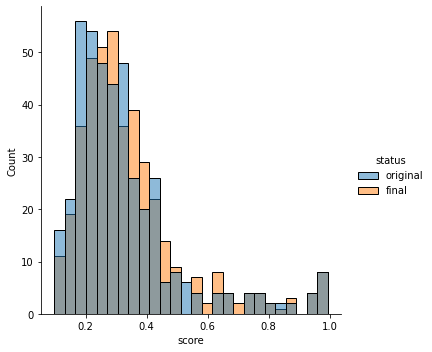

In [11]:
sns.displot(df_scores[(df_scores["epsilon"]>0)&(df_scores["method"]=="maincolors")], x="score", hue="status", kind="hist")

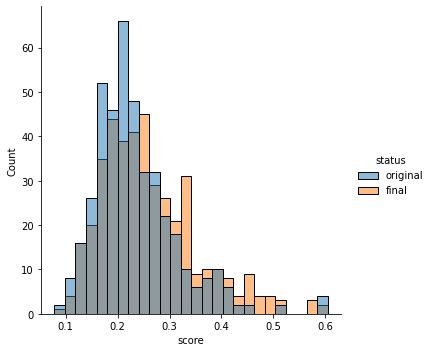

In [12]:
sns.displot(df_scores[(df_scores["epsilon"]>0)&(df_scores["method"]=="kmeans")], x="score", hue="status", kind="hist")

In [13]:
df_scores[df_scores["method"]=="maincolors"].groupby(["epsilon", "status", "method"]).mean()#.to_csv("./scores.csv")

score
epsilon status   method              
0       final    maincolors  0.325775
        original maincolors  0.324947
10      final    maincolors  0.339612
        original maincolors  0.324947
20      final    maincolors  0.349481
        original maincolors  0.324947

In [14]:
df_scores[df_scores["method"]=="kmeans"].groupby(["epsilon", "status", "method"]).mean()

score
epsilon status   method          
0       final    kmeans  0.234318
        original kmeans  0.234798
10      final    kmeans  0.254302
        original kmeans  0.234798
20      final    kmeans  0.267629
        original kmeans  0.234798

# Demonstration plots
## Main colors

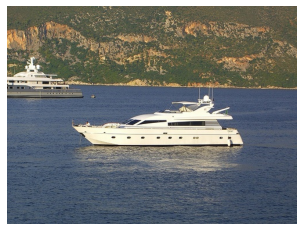

In [15]:
image = images[40]
plt.imshow(image)
plt.axis('off')
plt.show()

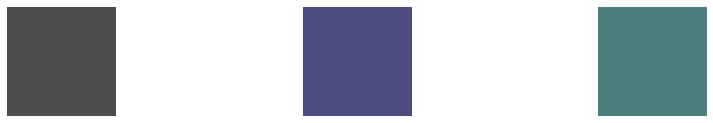

In [16]:
main_colors = maincolors.get_main_colors(image.reshape((-1, 3)), 0.06)
maincolors.show_main_colors(main_colors)

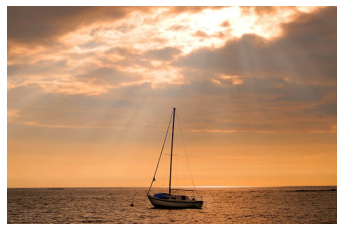

In [17]:
image = images[175]
plt.imshow(image)
plt.axis('off')
plt.show()

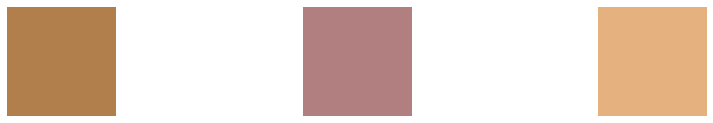

In [18]:
main_colors = maincolors.get_main_colors(image.reshape((-1, 3)), 0.1)
maincolors.show_main_colors(main_colors)

## Impact of epsilon

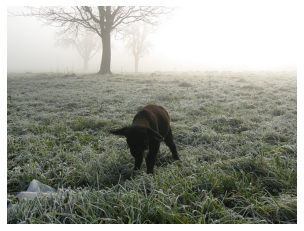

In [19]:
index = 75

image = images[index]
plt.imshow(image)
plt.axis('off')
plt.show()

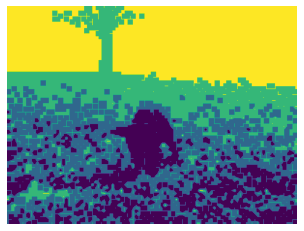

In [20]:
plt.imshow(outputs[0][index]["original_segmented_image"])
plt.axis('off')
plt.show()

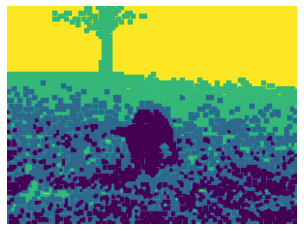

In [21]:
plt.imshow(outputs[0][index]["segmented_image"])
plt.axis('off')
plt.show()

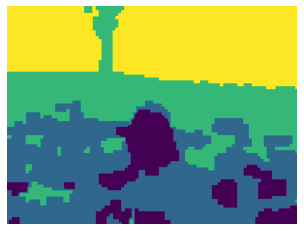

In [22]:
plt.imshow(outputs[1][index]["segmented_image"])
plt.axis('off')
plt.show()

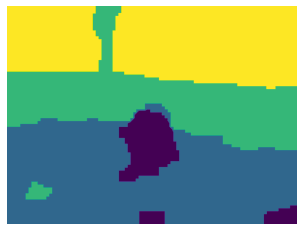

In [23]:
plt.imshow(outputs[2][index]["segmented_image"])
plt.axis('off')
plt.show()

## Some examples

In [29]:
def run(index):
    image = images[index]
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    plt.imshow(outputs[0][index]["original_segmented_image"])
    plt.axis('off')
    plt.show()
    
    
    plt.imshow(outputs[1][index]["segmented_image"])
    plt.axis('off')
    plt.show()
    

    plt.imshow(outputs[2][index]["segmented_image"])
    plt.axis('off')
    plt.show()

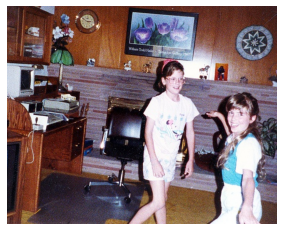

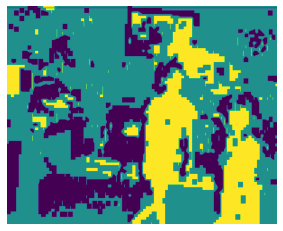

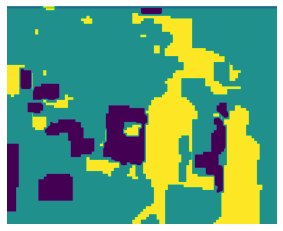

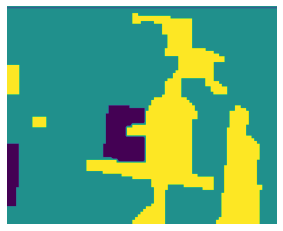

In [30]:
run(30)

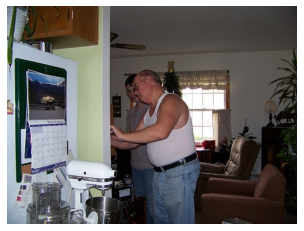

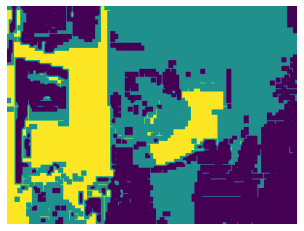

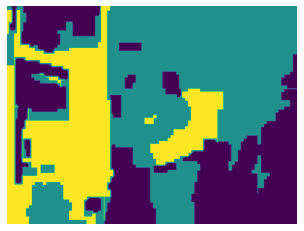

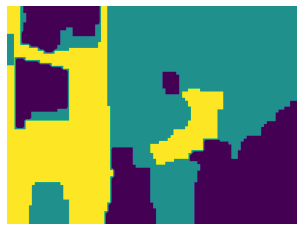

In [33]:
run(90)

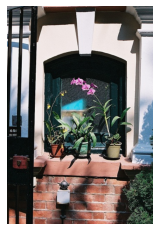

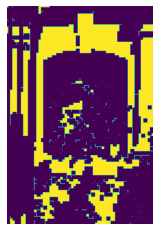

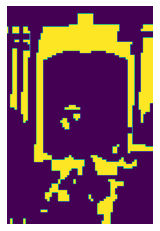

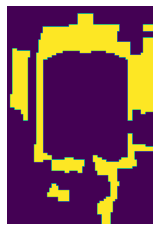

In [35]:
run(120)

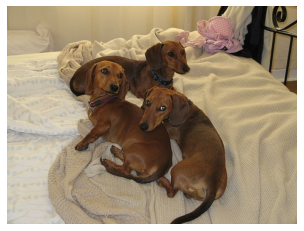

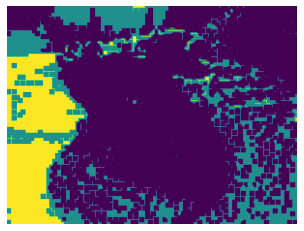

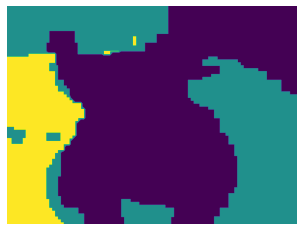

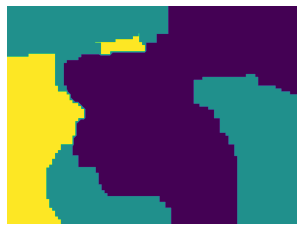

In [36]:
run(21)